In [1]:
import numpy as np
import rebound
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict

In [2]:
def wrapRad(theta):
    return (theta + np.pi) % (2*np.pi) - np.pi

$$ r = \frac{j_2}{j_1},\qquad 
\epsilon_1 = \mu_1 |C_1| e^{k_1},\qquad
\epsilon_2 = \mu_2 |C_2| e^{k_2}, \qquad
\nu = \frac{1}{\sqrt{3}}\frac{n_{r2}-n_{r1}}{n_{r1}} = \frac{1}{\sqrt{3}}\left(\frac{j_1(j_2+k_2)}{j_2(j_1-k_1)}\frac{n_2}{n_1}-1\right)$$

In [3]:
def calculateParam(ecc, j1, k1, j2, k2, P1, P2, mu1, mu2):
    # get r
    r = j2/j1

    # calculate C1 and C2
    coeff1 = (j1,-(j1-k1),0,-k1,0,0)
    C1 = df_coefficient_Ctilde(*coeff1,*(0,0,0,0))
    alpha1 = ((j1-k1)/j1)**(2/3)
    Cval1 = evaluate_df_coefficient_dict(C1,alpha1)

    coeff2 = (j2+k2,-j2,-k2,0,0,0)
    C2 = df_coefficient_Ctilde(*coeff2,*(0,0,0,0))
    alpha2 = (j2/(j2+k2))**(2/3)
    Cval2 = evaluate_df_coefficient_dict(C2,alpha2)

    # get e1 and e2
    epsilon1 = mu1 * abs(Cval1) * ecc**k1
    epsilon2 = mu2 * abs(Cval2) * ecc**k2

    # get nu
    n1 = 2*np.pi/P1
    n_r1 = (j1-k1) * n1 / j1
    n2 = 2*np.pi/P2
    n_r2 = (j2+k2) * n2 / j2
    nu = 1/np.sqrt(3) * (n_r2/n_r1 - 1)
    
    return r, nu, epsilon1, epsilon2

In [4]:
def calculateIC(P_0, lambda_0):
    # get p_0 and lambda_0
    phi_0 = wrapRad(j1* lambda_0)
    p_0 = -np.sqrt(3) * ((n_r1 / (2*np.pi/P_0))**(1/3) - 1)
    
    return phi_0, p_0

In [38]:
# user-defined parameters
ecc, j1, k1, j2, k2 = 0.01, 5, 1, 5, 1
P2_0 = (j2+k2)* j1 / ((j1-k1)*j2)
P1, P2 = 1, 0.97*P2_0
mu1, mu2 = 1e-6, 1e-6

r, nu, epsilon1, epsilon2 = calculateParam(ecc, j1, k1, j2, k2, P1, P2, mu1, mu2)

print(nu, 2*np.sqrt(epsilon1), 2*np.sqrt(epsilon2))

0.017856193892462593 0.00040416359914253585 0.00042219155771090115


In [39]:
P1, P2

(1, 1.455)

In [40]:
j1/(j1-k1)*P1*0.998

1.2475

In [46]:
# user-defined initial conditions (P_0, lambda_0)
ic = [[x,0] for x in np.linspace(j1/(j1-k1)*P1*0.998, j2/(j2+k2)*P2*1.01, 1)]

In [47]:
ic[0], ic[-1]

([1.2475, 0], [1.2475, 0])

In [48]:
# fig = rebound.OrbitPlot(sim, unitlabel='[AU]')

In [49]:
for P_0, lambda_0 in ic:
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1)
    sim.add(m=mu2, P=P2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    # track how system developes in time
    num = 51
    time = np.linspace(0,num-1,num)*2*np.pi/(r*nu)

    n_r1 = (j1-k1) * 2*np.pi / (j1*P1)
    n_r2 = (j2+k2) * 2*np.pi / (j2*P2)

    phi, p = np.zeros(num), np.zeros(num)
    for i,t in enumerate(time):
        try:
            sim.integrate(t)
        except rebound.Collision:
            print('Collision')
        info = sim.particles[3].calculate_orbit()
        
        phi[i] = wrapRad(j1*(info.l - n_r1*t))
        p[i] = -np.sqrt(3)*((n_r1 / info.n)**(1/3) - 1)
        
        print(info.l, info.P)

1.1521797116387233e-07 1.2475000000000007
1.0404093995720958 1.2467981489829674
1.9026056822779918 1.24720619953378
3.081728481350679 1.2471879609464922
3.865540260860255 1.2469567148429415
5.040955861956152 1.24730769475078
5.92583183315892 1.2468870128826772
0.6429071428652557 1.2472740469408126
1.7321074394891536 1.246927986060065
2.5521151177293966 1.2472520727293381
3.754027749776916 1.2470554094964186
4.55024322118787 1.2468912193212547
5.680565618795767 1.2473049668556702
0.3346912636378727 1.2467249277785986
1.2942854393649217 1.2474093046378776
2.4068634775152473 1.246875429658557
3.214719819042028 1.247052220734326
4.413198753708723 1.2472568385232397
5.221541741743 1.246874616302467
0.05250540895905509 1.247300336935591
1.02258879040901 1.2468974509010236
1.9336728803276593 1.2472744044398034
3.0935258242262127 1.2469588101290547
3.879127141212237 1.2471699183671205
5.071302300329829 1.2471383667220082
5.913697701251902 1.2469006312307123
0.6900937021317279 1.247423915528559

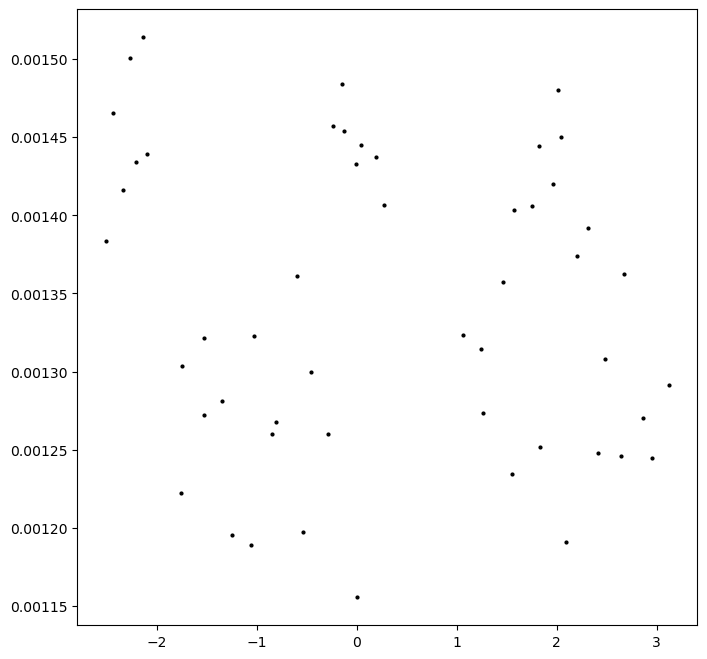

In [50]:
plt.scatter(phi,p,[4],color='black')
plt.show()

In [12]:
def hamilton(y,t,e1,e2,r,nu):
    phi, p = y
    dydt = [p, -e1*np.sin(phi) - r*e2*np.sin(r*(phi-nu*t))]
    return dydt

In [13]:
def phasePlot(e1, e2, r, nu, ic):
    num = 201  # number of sampled time
    t = np.linspace(0,num-1,num)*2*np.pi/(r*nu)
    
    plt.rcParams["figure.figsize"] = (8,8)
    for y0 in ic:
        sol = odeint(hamilton, y0, t, args=(e1,e2,r,nu))
        phi = (sol[:,0] + np.pi * np.ones(num)) % (2*np.pi) - np.pi * np.ones(num)  # wrap into [-pi,pi]
        plt.plot(phi, sol[:,1], 'k.', ms=0.2)
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$p$')
    plt.title(fr'phase-space plot for $\nu={nu}$')
    plt.show()

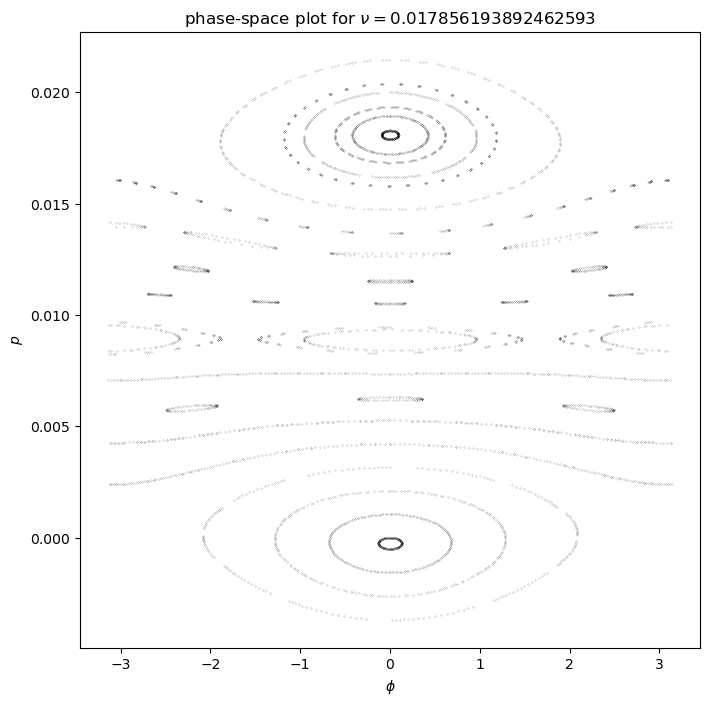

In [14]:
ic = [[0,y] for y in np.linspace(0, 0.02, 20)]
phasePlot(epsilon1, epsilon2, r, nu, ic)